## Classifying our variables

Our current variables can be classified as either categorical or numerical data, as shown:

| Categorical            | Numerical                | Mixed                        |
|------------------------|--------------------------|------------------------------|
| `domain_in_ip`         | `length_url`             | `time_domain_activation`     |
| `url_shortened`        |                          | `time_domain_expiration`     |
| `tls_ssl_certificate`  |                          | `qty_at_url`                 |
| `url_google_index`     |                          | `qty_dot_domain`             |
| `domain_google_index`  |                          | `qty_hyphen_domain`          |
| `phishing`             |                          |                              |

<br>

The reason `time_domain_activation`, `time_domain_expiration`, `qty_at_url`, `qty_dot_domain` and `qty_hyphen_domain` are mixed is due to a two-part process:
1. Determine if the attribute exists and is non-null (categorical). 
2. If it does, we then analyse the numerical values to assess for potential phishing activity.

---

## Analysing Categorical Data

For analysing the catgorical variables against the `phishing` variable (which is also a categorical variable), we will follow a two-stage approach:

1. **Hypothesis Testing**: Employ the Chi-Square Test of Independence to examine the relationship. A contingency table (cross-tabulation) will be used to visualise the observed frequencies.

    - **Null Hypothesis (H0)**: There is no relationship between the categorical variable and whether a site is a phishing site. The two are independent.
    - **Alternative Hypothesis (H1)**: There is a relationship between the categorical variable and whether a site is a phishing site. The two are not independent.

2. **Phi Coefficient**: Measure the strength and direction of association between binary categorical variables. This mirrors how Pearson's Coefficient is used for numerical data.

In [1]:
# Open the datasets and import libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score


url_information = pd.read_csv('../datasets/sampled_url_information.csv')

In [2]:
# Create the contingency tables
ip_vs_phishing = pd.crosstab(url_information['domain_in_ip'], url_information['phishing'])
shortened_vs_phishing = pd.crosstab(url_information['url_shortened'], url_information['phishing'])
certificate_vs_phishing = pd.crosstab(url_information['tls_ssl_certificate'], url_information['phishing'])

# We remove dataset entries with a value of -1. 
# These entries represent URLs/domains that Google Search cannot index.
urlgoogle_filtered = url_information[(url_information['url_google_index'] != -1)]
domaingoogle_filtered = url_information[(url_information['domain_google_index'] != -1)]

urlgoogle_vs_phishing = pd.crosstab(urlgoogle_filtered['url_google_index'], url_information['phishing'])
domaingoogle_vs_phishing = pd.crosstab(domaingoogle_filtered['domain_google_index'], url_information['phishing'])

In [4]:
def displayContingencyTable(contingency_table):
    # Performing Chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Calculate the Phi Coefficient
    phi = np.sqrt(chi2 / contingency_table.to_numpy().sum())

    print(f"Chi-square Statistic: {chi2}, p-value: {p}, Phi Coefficient: {phi:.3f}")

    # Interpretation of the result
    if p < 0.05:
        print("There is a significant relationship between the two variables.")
    else:
        print("There is no significant relationship between the two variables.")

    # Plotting the heatmap
    x_label = 'phishing'
    y_label = contingency_table.index.name
    title = f'Heatmap of {y_label} vs. {x_label}'

    plt.figure(figsize=(6, 4)) 
    sb.heatmap(contingency_table, annot=True, fmt='g')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()


Chi-square Statistic: 20.401182410872465, p-value: 6.279098696288341e-06, Phi Coefficient: 0.143
There is a significant relationship between the two variables.


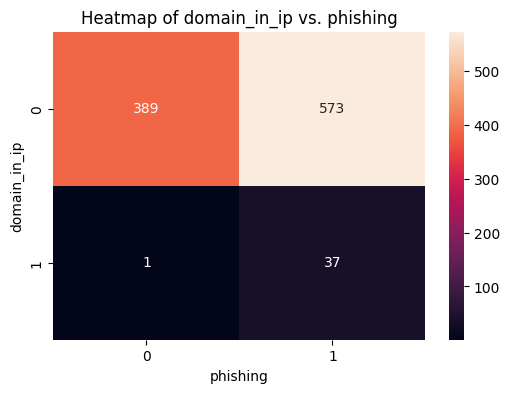

Chi-square Statistic: 13.487153215636827, p-value: 0.00024020234060995253, Phi Coefficient: 0.116
There is a significant relationship between the two variables.


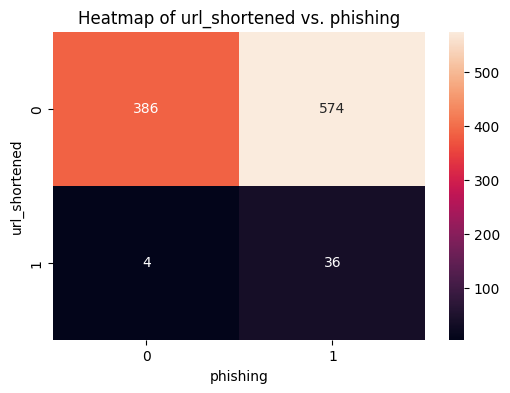

Chi-square Statistic: 4.927724573246753, p-value: 0.026429096063403993, Phi Coefficient: 0.070
There is a significant relationship between the two variables.


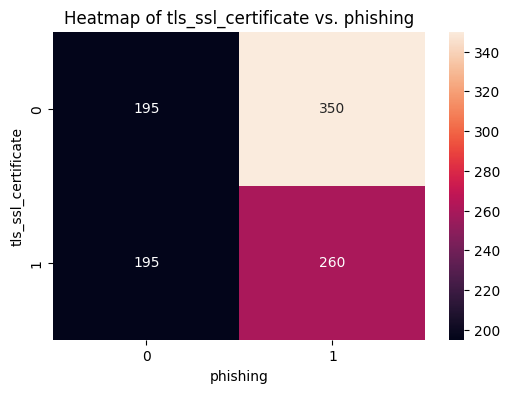

Chi-square Statistic: 47.22037174381603, p-value: 6.3437677434831234e-12, Phi Coefficient: 0.219
There is a significant relationship between the two variables.


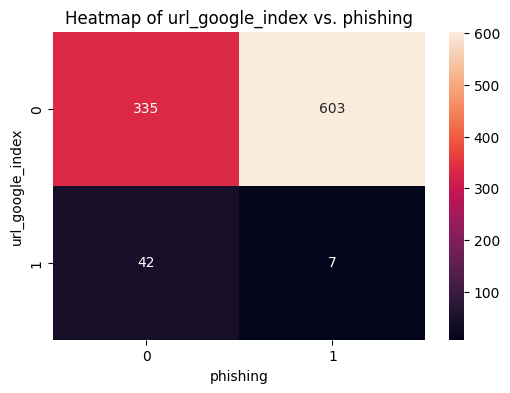

Chi-square Statistic: 25.83341619160278, p-value: 3.721887435456248e-07, Phi Coefficient: 0.162
There is a significant relationship between the two variables.


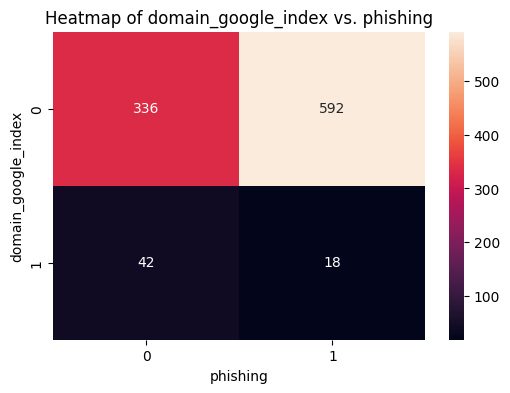

In [5]:
contingency_tables = [
    ip_vs_phishing,
    shortened_vs_phishing,
    certificate_vs_phishing,
    urlgoogle_vs_phishing,
    domaingoogle_vs_phishing
]

for table in contingency_tables:
    displayContingencyTable(table)

Our contingency tables reveal a statistically significant dependence between the selected categorical variables and phishing activity. This is evidenced by high Chi-Square statistics (10-40~) and low p-values (<0.05), indicating that the observed patterns are unlikely to be due to chance. However, while dependence is established, the Phi Coefficient indicates very low correlation (< 0.2) among the categorical variables.

We believe that this low correlation may be due to under-representation of positive values in the categorical variables (< 10% of the sample). To explore this, we calculated the proportion of phishing websites within the subset of positive categorical variables.

In [6]:
def calculate_proportion_for_category(contingency_tables_dict):
    for category, table in contingency_tables_dict.items():
        if 1 in table.index:
            total = table.loc[1].sum()
            if total != 0:
                phishing_cases = table.loc[1, 1]
                proportion = phishing_cases / total
                print(f"Proportion of phishing sites when '{category}' is 1: {proportion:.2f}")
            else:
                print(f"No cases where '{category}' is 1.")
        else:
            print(f"No cases where '{category}' is 1.")

contingency_tables_dict = {
    'domain_in_ip': ip_vs_phishing,
    'url_shortened': shortened_vs_phishing,
    'tls_ssl_certificate': certificate_vs_phishing,
    'url_google_index': urlgoogle_vs_phishing,
    'domain_google_index': domaingoogle_vs_phishing,
}

calculate_proportion_for_category(contingency_tables_dict)


Proportion of phishing sites when 'domain_in_ip' is 1: 0.97
Proportion of phishing sites when 'url_shortened' is 1: 0.90
Proportion of phishing sites when 'tls_ssl_certificate' is 1: 0.57
Proportion of phishing sites when 'url_google_index' is 1: 0.14
Proportion of phishing sites when 'domain_google_index' is 1: 0.30


Our analysis highlights the following correlations with phishing activity:

- Positive: `domain_in_ip` and `url_shortened` exhibit stronger positive correlations.
- Negative: `url_google_index` and `domain_google_index` demonstrate negative correlations.
- Weak Indicator: `tls_ssl_certificate` appears less reliable as an indicator due to its weak correlation, further supported by its low Chi-Statistic and p-value.

---

## Analysing Numerical Data

For analysing the numerical variables against the `phishing` variable, we will follow a three-stage approach:

1. **Basic Statistical Analysis**: Analysing basic summary statistics offers quick insights into how the data is distributed.
2. **Visualisation**: Box plots and Violin Plots can help illustrate the distribution of each numerical variable for both phishing and non-phishing websites, 
3. **Cleaning**: We will remove outliers to reduce data variability and obtain a more reliable representation of the data.


In [7]:
# Visualise the distribution using a box plot and violin plot
def displayBoxPlot(numerical_data, df):
    plt.figure(figsize=(6, 6))
    sb.boxplot(x='phishing', y=numerical_data, data=df)
    plt.title(f'Box Plot of `{numerical_data}` by Phishing Status')
    plt.xlabel('Phishing Status')
    plt.ylabel(numerical_data)
    plt.xticks([0, 1], ['Non-Phishing', 'Phishing'])
    plt.show()

def displayViolinPloit(numerical_data, df):
    plt.figure(figsize=(6, 6))
    sb.violinplot(x='phishing', y=numerical_data, data=df)
    plt.title(f'Violin Plot of `{numerical_data}` by Phishing Status')
    plt.xlabel('Phishing Status')
    plt.ylabel(numerical_data)
    plt.show()

# Removal of outliers to get a better sense of the data
def removeOutlier(numerical_data, column, phishing_status):
    # Filter the data based on phishing status
    filtered_data = numerical_data[numerical_data['phishing'] == phishing_status]

    # Calculate outliers
    q1 = filtered_data[column].quantile(0.25)
    q3 = filtered_data[column].quantile(0.75)
    iqr = q3 - q1  # The Inter-Quartile Range

    # Define the lower and upper bounds for outliers
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Filter outliers
    outliers = filtered_data.loc[(filtered_data[column] <= lower_bound) | (filtered_data[column] >= upper_bound)]

    return outliers

Before Outlier Removal
          count       mean        std  min    25%   50%    75%    max
phishing                                                             
0         390.0  20.379487  10.879314  6.0  15.00  18.0   23.0  120.0
1         610.0  91.301639  81.612188  8.0  40.25  67.0  104.0  677.0


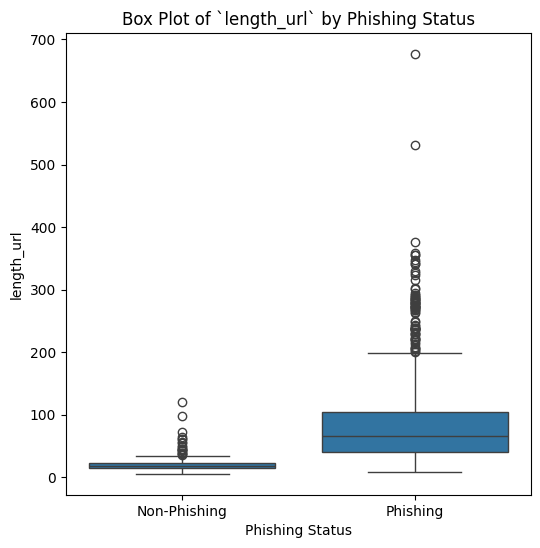

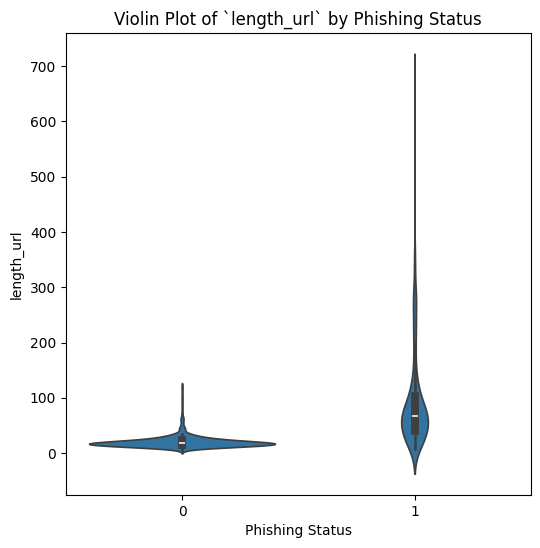

After Outlier Removal
          count       mean        std  min   25%   50%   75%    max
phishing                                                           
0         369.0  18.466125   5.666412  6.0  14.0  18.0  22.0   34.0
1         536.0  65.518657  37.614021  8.0  37.0  62.0  83.0  199.0


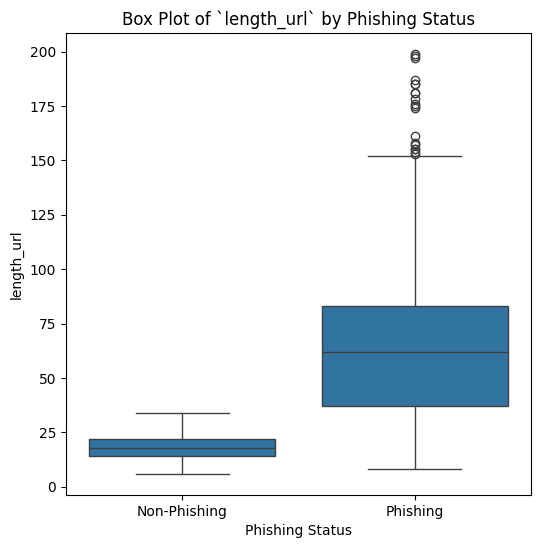

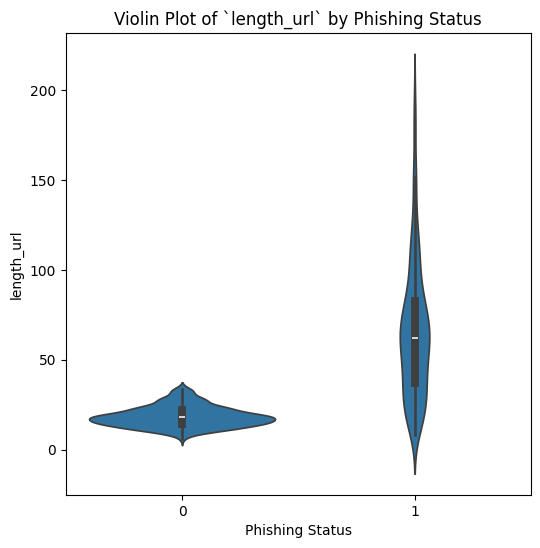

In [8]:
# Observe that The mean and median URL length of phishing websites consistently exceeds that of non-phishing websites, even after removing outliers.

# Before outlier removal
print("Before Outlier Removal")
summary_statistics = url_information.groupby('phishing')['length_url'].describe()
print(summary_statistics)
displayBoxPlot('length_url', url_information)
displayViolinPloit('length_url', url_information)

# Perform outlier removal
outliers_phishing = removeOutlier(url_information, 'length_url', 1)  # For phishing websites
outliers_non_phishing = removeOutlier(url_information, 'length_url', 0)  # For non-phishing websites
outliers_total = pd.concat([outliers_phishing, outliers_non_phishing]).drop_duplicates()
clean_data = url_information.loc[~url_information.index.isin(outliers_total.index)]

# After outlier removal
print("After Outlier Removal")
summary_statistics = clean_data.groupby('phishing')['length_url'].describe()
print(summary_statistics)
displayBoxPlot('length_url', clean_data)
displayViolinPloit('length_url', clean_data)

Based on the summary statistics and visualisations, we can observe that `length_url` stands out as a reliable indicator of potential phishing URLs. The longer the URL, the higher the probability of it being a phishing attempt.

---
## Analysing Mixed Variables

For analysing the mixed variables against the `phishing` variable , we will seperate the analysis into **Categorical** and **Numerical**

1. **Categorical**: Use Contingency Tables to assess whether the presence of the variable influences the classification as a phishing or non-phishing website.
2. **Numerical**: Use Basic Summary Statistics to compare the distributions of non-null variables between phishing and non-phishing websites.

Chi-square Statistic: 3.385867736975356, p-value: 0.06575755687592916
There is no significant association between the two variables.


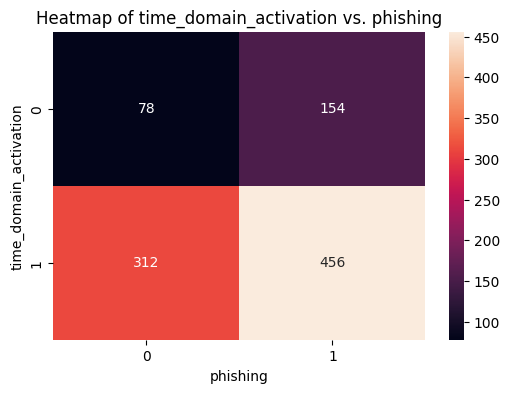

Chi-square Statistic: 6.206957823839819, p-value: 0.012724912811725345
There is a significant association between the two variables.


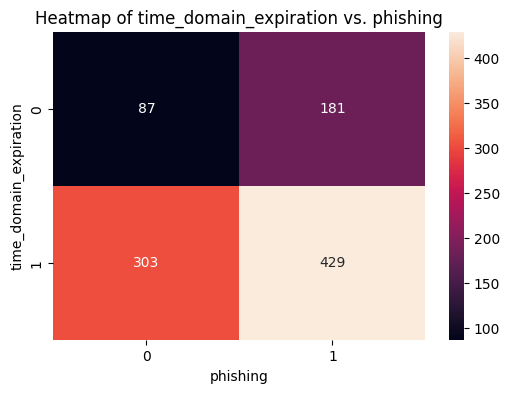

Chi-square Statistic: 321.42306556253584, p-value: 7.094615555901861e-72
There is a significant association between the two variables.


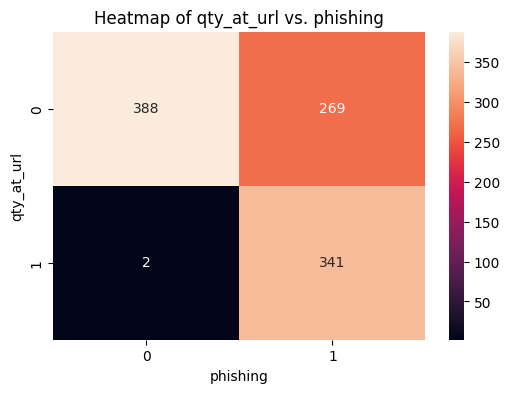

Chi-square Statistic: 1.7764315482414175, p-value: 0.18258812297761656
There is no significant association between the two variables.


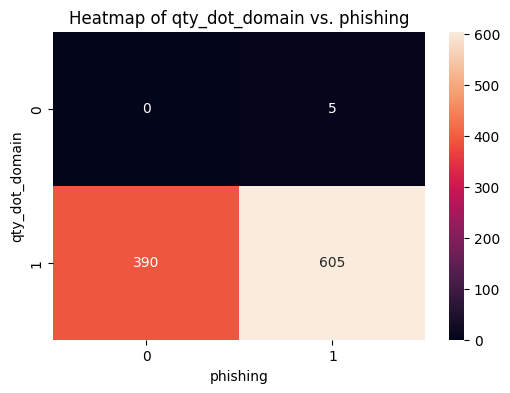

Chi-square Statistic: 0.341654273602013, p-value: 0.5588758967578324
There is no significant association between the two variables.


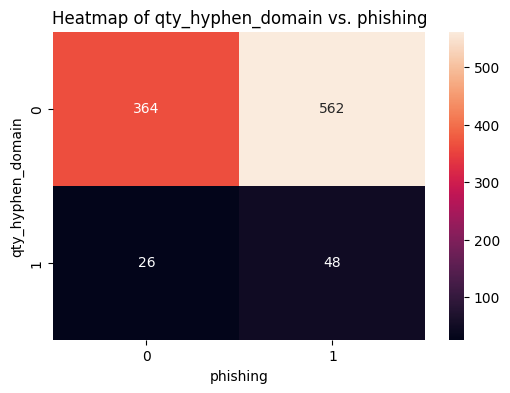

In [33]:
# Categorical Analysis

mixed = [
    'time_domain_activation', 
    'time_domain_expiration', 
    'qty_at_url', 
    'qty_dot_domain', 
    'qty_hyphen_domain'
]

for column in mixed:
    categorical = pd.Series(np.where(url_information[column] <= 0, 0, 1), name=column) # Convert all values <= 0 into 0, and all positive non-zero values into 1
    contingency_table = pd.crosstab(categorical, url_information['phishing'])
    displayContingencyTable(contingency_table) # Refer to the function definition at the start of this file

In [34]:
# Numerical Analysis

for column in mixed:
    numerical = url_information[(url_information[column] != 0) & (url_information[column] != -1)] # Get all positive non-zero values of each column
    summary_statistics = numerical.groupby('phishing')[column].describe() # Group based on phishing values with and describe with respect to the mixed column values
    print(f'Summary Statistics for {column}')
    print(summary_statistics)
    print('\n')

Summary Statistics for time_domain_activation
          count         mean          std   min      25%     50%      75%  \
phishing                                                                    
0         312.0  5680.682692  2221.892633  38.0  4442.75  6288.0  7287.25   
1         456.0  2521.302632  1904.361525   8.0  1063.25  2162.5  3591.25   

              max  
phishing           
0         11142.0  
1          7996.0  


Summary Statistics for time_domain_expiration
          count        mean         std  min    25%    50%    75%     max
phishing                                                                 
0         303.0  526.442244  648.030273  2.0  176.5  309.0  607.0  3590.0
1         429.0  367.778555  463.877255  1.0  120.0  243.0  361.0  3160.0


Summary Statistics for qty_at_url
          count      mean       std  min  25%  50%  75%   max
phishing                                                     
0           2.0  1.000000  0.000000  1.0  1.0  1.0  1.0   1.0

Observe that `qty_at_url` functions more like a categorical variable. Out of 343 URLs containing '@' symbols, a staggering 341 are phishing websites – this strongly indicates that the '@' symbol is a reliable phishing marker.  

Meanwhile, `time_domain_activation` and `time_domain_expiration` behave as numerical variables. This aligns with our initial hypothesis: phishing domains typically have shorter lifespans and closer expiration dates, suggesting  they are hastily set up with short-term goals. 

Finally, neither `qty_dot_domain` nor `qty_hyphen_domain` appear to have a strong correlation with phishing websites. Both the contingency tables and summary statistics demonstrate a weak relationship between these variables and phishing activity. 
